Here we will use a Restricted Boltzmann Machine (RBM) in a Collaborative Filtering based recommendation system. This system is an algorithm that recommends items by trying to find users that are similar to each other based on their item ratings. 

<a id="ref1"></a>
<h2>Acquiring the Data</h2>

To start, we need to download the data we are going to use for our system. The datasets we are going to use were acquired by <a href="http://grouplens.org/datasets/movielens/">GroupLens</a> and contain movies, users and movie ratings by these users.

After downloading the data, we will extract the datasets to a directory that is easily accessible.

In [1]:
!wget -O ./data/moviedataset.zip http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip -o ./data/moviedataset.zip -d ./data

--2020-08-24 10:28:51--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘./data/moviedataset.zip’

./data/moviedataset 100%[===================>]   5.64M  12.0MB/s    in 0.5s    

2020-08-24 10:28:52 (12.0 MB/s) - ‘./data/moviedataset.zip’ saved [5917549/5917549]

Archive:  ./data/moviedataset.zip
   creating: ./data/ml-1m/
  inflating: ./data/ml-1m/movies.dat  
  inflating: ./data/ml-1m/ratings.dat  
  inflating: ./data/ml-1m/README     
  inflating: ./data/ml-1m/users.dat  


With the datasets in place, let's now import the necessary libraries. We will be using <a href="https://www.tensorflow.org/">Tensorflow</a> and <a href="http://www.numpy.org/">Numpy</a> together to model and initialize our Restricted Boltzmann Machine and <a href="http://pandas.pydata.org/pandas-docs/stable/">Pandas</a> to manipulate our datasets. To import these libraries, run the code cell below.

In [2]:
#Tensorflow library. Used to implement machine learning models
import tensorflow as tf
#Numpy contains helpful functions for efficient mathematical calculations
import numpy as np
#Dataframe manipulation library
import pandas as pd
#Graph plotting library
import matplotlib.pyplot as plt
%matplotlib inline

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jupyterlab/conda/envs/python/lib/python3

<a id="ref2"></a>
<h2>Loading in the Data</h2>

Let's begin by loading in our data with Pandas. The .dat files containing our data are similar to CSV files, but instead of using the ',' (comma) character to separate entries, it uses '::' (two colons) characters instead. To let Pandas know that it should separate data points at every '::', we have to specify the <code>sep='::'</code> parameter when calling the function.

Additionally, we also pass it the <code>header=None</code> parameter due to the fact that our files don't contain any headers.

Let's start with the movies.dat file and take a look at its structure:

In [3]:
#Loading in the movies dataset
movies_df = pd.read_csv('./data/ml-1m/movies.dat', sep='::', header=None, engine='python')
movies_df.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


We can do the same for the ratings.dat file:

In [4]:
#Loading in the ratings dataset
ratings_df = pd.read_csv('./data/ml-1m/ratings.dat', sep='::', header=None, engine='python')
ratings_df.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


So our <b>movies_df</b> variable contains a dataframe that stores a movie's unique ID number, title and genres, while our <b>ratings_df</b> variable stores a unique User ID number, a movie's ID that the user has watched, the user's rating to said movie and when the user rated that movie.

Let's now rename the columns in these dataframes so we can better convey their data more intuitively:

In [5]:
movies_df.columns = ['MovieID', 'Title', 'Genres']
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


And our final ratings_df:

In [6]:
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


<hr>

<a id="ref3"></a>
<h2>The Restricted Boltzmann Machine model</h2>

<img src="https://ibm.box.com/shared/static/o049tx0dsllpbj3b546vuba25qqlzelq.png"  width="300">
<br>
The Restricted Boltzmann Machine model has two layers of neurons, one of which is what we call a visible input layer and the other is called a hidden layer. The hidden layer is used to learn features from the information fed through the input layer. For our model, the input is going to contain X neurons, where X is the amount of movies in our dataset. Each of these neurons will possess a normalized rating value varying from 0 to 1, where 0 meaning that a user has not watched that movie and the closer the value is to 1, the more the user likes the movie that neuron's representing. These normalized values, of course, will be extracted and normalized from the ratings dataset.

After passing in the input, we train the RBM on it and have the hidden layer learn its features. These features are what we use to reconstruct the input, which in our case, will predict the ratings for movies that user hasn't watched, which is exactly what we can use to recommend movies!

We will now begin to format our dataset to follow the model's expected input.

<h3>Formatting the Data</h3>

First let's see how many movies we have and see if the movie ID's correspond with that value:

In [7]:
len(movies_df)

3883

Now, we can start formatting the data into input for the RBM. We're going to store the normalized users ratings into as a matrix of user-rating called trX, and normalize the values.

In [8]:
user_rating_df = ratings_df.pivot(index='UserID', columns='MovieID', values='Rating')
user_rating_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Lets normalize it now:

In [9]:
norm_user_rating_df = user_rating_df.fillna(0) / 5.0
trX = norm_user_rating_df.values
trX[0:5]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<a id="ref4"></a>
<h2>Setting the Model's Parameters</h2>

Next, let's start building our RBM with TensorFlow. We'll begin by first determining the number of neurons in the hidden layers and then creating placeholder variables for storing our visible layer biases, hidden layer biases and weights that connects the hidden layer with the visible layer. We will be arbitrarily setting the number of neurons in the hidden layers to 20. You can freely set this value to any number you want since each neuron in the hidden layer will end up learning a feature.

In [10]:
hiddenUnits = 20
visibleUnits =  len(user_rating_df.columns)
vb = tf.placeholder("float", [visibleUnits]) #Number of unique movies
hb = tf.placeholder("float", [hiddenUnits]) #Number of features we're going to learn
W = tf.placeholder("float", [visibleUnits, hiddenUnits])

We then move on to creating the visible and hidden layer units and setting their activation functions. In this case, we will be using the <code>tf.sigmoid</code> and <code>tf.relu</code> functions as nonlinear activations since it is commonly used in RBM's.

In [11]:
#Phase 1: Input Processing
v0 = tf.placeholder("float", [None, visibleUnits])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))
#Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

Now we set the RBM training parameters and functions.

In [12]:
#Learning rate
alpha = 1.0
#Create the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
#Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])
#Create methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

And set the error function, which in this case will be the Mean Absolute Error Function.

In [13]:
err = v0 - v1
err_sum = tf.reduce_mean(err * err)

We also have to initialize our variables. Thankfully, NumPy has a handy ,code>zeros</code> function for this. We use it like so:

In [14]:
#Current weight
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
#Current visible unit biases
cur_vb = np.zeros([visibleUnits], np.float32)
#Current hidden unit biases
cur_hb = np.zeros([hiddenUnits], np.float32)
#Previous weight
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
#Previous visible unit biases
prv_vb = np.zeros([visibleUnits], np.float32)
#Previous hidden unit biases
prv_hb = np.zeros([hiddenUnits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Now we train the RBM with 15 epochs with each epoch using 10 batches with size 100. After training, we print out a graph with the error by epoch.

0.059519514
0.050534092
0.04867562
0.04760357
0.04674081
0.04653546
0.046330173
0.04582349
0.045800086
0.045353048
0.045204084
0.045150906
0.045229983
0.04520039
0.04511445


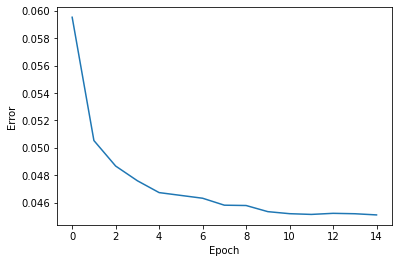

In [15]:
epochs = 15
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print (errors[-1])
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

<a id="ref5"></a>
<h2>Recommendation</h2>

We can now predict movies that an arbitrarily selected user might like. This can be accomplished by feeding in the user's watched movie preferences into the RBM and then reconstructing the input. The values that the RBM gives us will attempt to estimate the user's preferences for movies that he hasn't watched based on the preferences of the users that the RBM was trained on.

Lets first select a <b>User ID</b> of our mock user:

In [16]:
mock_user_id = 215

In [17]:
#Selecting the input user
inputUser = trX[mock_user_id-1].reshape(1, -1)
inputUser[0:5]

array([[0.8, 0. , 0. , ..., 0. , 0. , 0. ]])

In [18]:
#Feeding in the user and reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})
print(rec)

[[0.44319758 0.1751246  0.02183115 ... 0.00177005 0.00144248 0.01015799]]


We can then list the 20 most recommended movies for our mock user by sorting it by their scores given by our model.

In [19]:
scored_movies_df_mock = movies_df[movies_df['MovieID'].isin(user_rating_df.columns)]
scored_movies_df_mock = scored_movies_df_mock.assign(RecommendationScore = rec[0])
scored_movies_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)

,MovieID,Title,Genres,RecommendationScore
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,0.961617
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.902110
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,0.871086
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,0.843219
2693,2762,"Sixth Sense, The (1999)",Thriller,0.779490
2559,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi,0.750955
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,0.706709
585,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,0.698173
1539,1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,0.657481
3045,3114,Toy Story 2 (1999),Animation|Children's|Comedy,0.633083


So, how to recommend the movies that the user has not watched yet? 

Now, we can find all the movies that our mock user has watched before:

In [20]:
movies_df_mock = ratings_df[ratings_df['UserID'] == mock_user_id]
movies_df_mock.head()

,UserID,MovieID,Rating,Timestamp
31603,215,3793,5,977099259
31604,215,1,4,979174987
31605,215,1197,5,976899663
31606,215,2302,5,976899718
31607,215,2167,5,976899770


In the next cell, we merge all the movies that our mock users has watched with the predicted scores based on his historical data:

In [21]:
#Merging movies_df with ratings_df by MovieID
merged_df_mock = scored_movies_df_mock.merge(movies_df_mock, on='MovieID', how='outer')

lets sort it and take a look at the first 20 rows:

In [22]:
merged_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)

,MovieID,Title,Genres,RecommendationScore,UserID,Rating,Timestamp
253,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,0.961617,215.0,5.0,976899190.0
2374,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.902110,NaN,NaN,NaN
1106,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,0.871086,NaN,NaN,NaN
1120,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,0.843219,215.0,5.0,976899689.0
2557,2762,"Sixth Sense, The (1999)",Thriller,0.779490,NaN,NaN,NaN
2426,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi,0.750955,215.0,5.0,976908635.0
466,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,0.706709,215.0,5.0,976899784.0
575,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,0.698173,NaN,NaN,NaN
1449,1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,0.657481,NaN,NaN,NaN
2898,3114,Toy Story 2 (1999),Animation|Children's|Comedy,0.633083,NaN,NaN,NaN


As you can see, there are some movies that user has not watched yet and has high score based on our model. So, we can recommend them to the use. This is RBM model, its applications and how it works with TensorFlow.

<hr>